In [1]:
import lightning.pytorch as pl
import pytorch_forecasting as pf

print("PyTorch Lightning version:", pl.__version__)
print("PyTorch Forecasting version:", pf.__version__)

PyTorch Lightning version: 2.3.3
PyTorch Forecasting version: 1.0.0


/home/rosh/miniforge3/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [29]:
import xarray as xr
import ocf_blosc2
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer


from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer

import seaborn as sns
import matplotlib.pyplot as plt
# from lightning.pytorch.tuner.lr_finder import LearningRateFinder

from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.tuner.tuning import Tuner



In [3]:

print(issubclass(TemporalFusionTransformer, pl.LightningModule))


True


In [4]:
forecast_data = pd.read_csv("result_data/data_tft_36.csv")
print(forecast_data.shape)
forecast_data = forecast_data.drop(columns=['Unnamed: 0'])
forecast_data = forecast_data.sort_values(['ss_id', 'pv_datetime'])
forecast_data['ss_id'] = forecast_data['ss_id'].astype(int)
forecast_data['pv_datetime'] = pd.to_datetime(forecast_data['pv_datetime'])
forecast_data['date'] = forecast_data['pv_datetime'].dt.date
forecast_data['day_of_week'] = forecast_data['pv_datetime'].dt.dayofweek
forecast_data['month'] = forecast_data['pv_datetime'].dt.month


(11952, 26)


In [5]:
forecast_data.head()

,ss_id,init_time,step,generation,pv_datetime,pv_hour,hour,lat,long,tilt,...,sr,t2m,tcc,u10,u100,v10,v100,date,day_of_week,month
5832,2626,2019-02-13 00:00:00,0 days 00:00:00,0.0,2019-02-12 23:00:00,23.0,1.0,54.99,-3.18,22.0,...,0.0,281.21753,0.993683,1.998593,3.772186,3.417703,6.584270,2019-02-12,1,2
5833,2626,2019-02-13 00:00:00,0 days 01:00:00,0.0,2019-02-13 00:00:00,0.0,2.0,54.99,-3.18,22.0,...,0.0,281.70947,0.999939,2.529497,4.472948,4.112045,7.254433,2019-02-13,2,2
5834,2626,2019-02-13 00:00:00,0 days 02:00:00,0.0,2019-02-13 01:00:00,1.0,3.0,54.99,-3.18,22.0,...,0.0,281.86400,0.999786,2.997723,5.072718,4.938729,8.480017,2019-02-13,2,2
5835,2626,2019-02-13 00:00:00,0 days 03:00:00,0.0,2019-02-13 02:00:00,2.0,4.0,54.99,-3.18,22.0,...,0.0,281.76953,0.998024,3.551091,5.737916,6.641625,10.684008,2019-02-13,2,2
5836,2626,2019-02-13 00:00:00,0 days 04:00:00,0.0,2019-02-13 03:00:00,3.0,5.0,54.99,-3.18,22.0,...,0.0,281.46997,0.999996,3.081366,5.090918,6.080827,9.852675,2019-02-13,2,2


In [6]:
forecast_data.columns

Index(['ss_id', 'init_time', 'step', 'generation', 'pv_datetime', 'pv_hour',
       'hour', 'lat', 'long', 'tilt', 'orientation', 'dlwrf', 'dswrf', 'duvrs',
       'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10',
       'v100', 'date', 'day_of_week', 'month'],
      dtype='object')

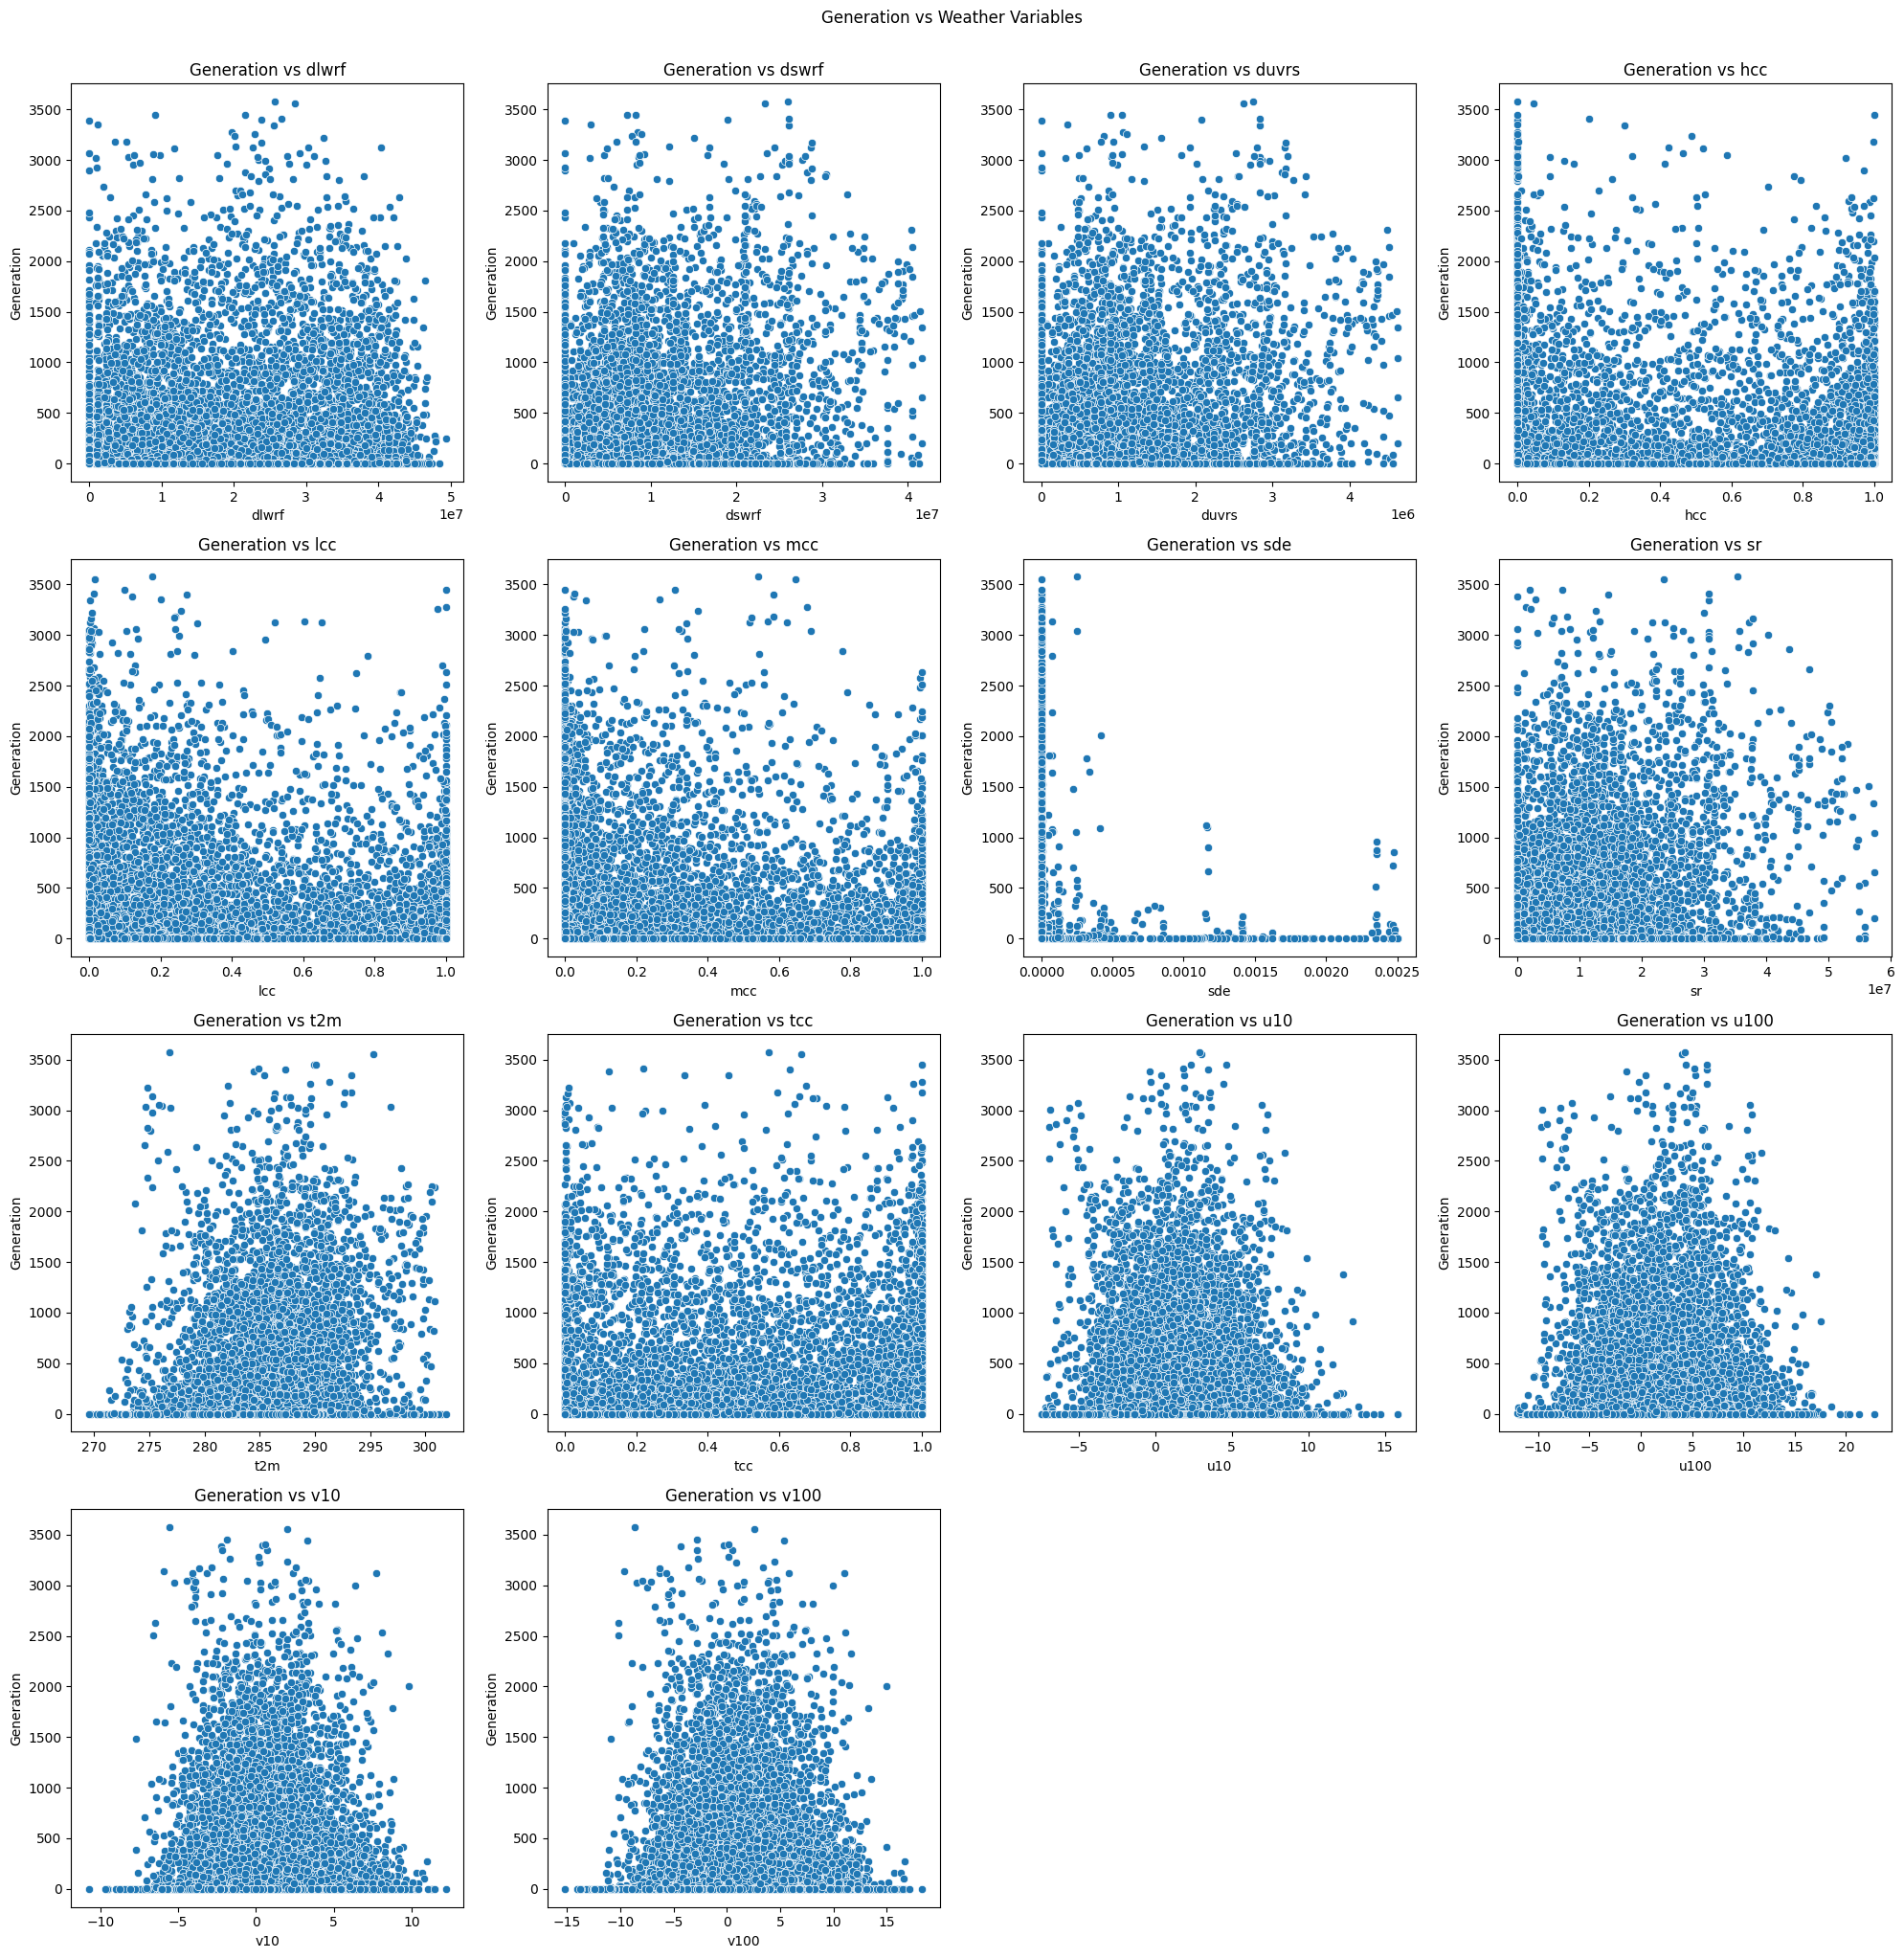

In [7]:
weather_variables = ['dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10', 'v100']


num_vars = len(weather_variables)
cols = 4
rows = (num_vars + cols - 1) // cols  # Ceiling division for grid layout

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, var in enumerate(weather_variables):
    sns.scatterplot(data=forecast_data, x=var, y='generation', ax=axes[i])
    axes[i].set_title(f'Generation vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Generation')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Generation vs Weather Variables', y=1.02)
plt.show()

In [8]:
target_variable = 'generation'
static_features = ['ss_id', 'lat', 'long', 'tilt', 'orientation']
known_future_inputs = [
    'dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 
    't2m', 'tcc', 'u10', 'u100', 'v10', 'v100', 'day_of_week', 'month', 'hour'
]

required_columns = static_features + known_future_inputs + [target_variable, 'pv_datetime', 'date']

forecast_data = forecast_data[required_columns]

forecast_data = forecast_data.fillna(method='bfill').fillna(method='ffill')

forecast_data['time_idx'] = forecast_data.index

In [9]:
# print(forecast_data.columns)

# forecast_data.dtypes

In [10]:
forecast_data.head()

,ss_id,lat,long,tilt,orientation,dlwrf,dswrf,duvrs,hcc,lcc,...,u100,v10,v100,day_of_week,month,hour,generation,pv_datetime,date,time_idx
5832,2626,54.99,-3.18,22.0,270.0,0.0,0.0,0.0,0.840149,0.972809,...,3.772186,3.417703,6.584270,1,2,1.0,0.0,2019-02-12 23:00:00,2019-02-12,5832
5833,2626,54.99,-3.18,22.0,270.0,1253060.9,0.0,0.0,0.989410,0.996460,...,4.472948,4.112045,7.254433,2,2,2.0,0.0,2019-02-13 00:00:00,2019-02-13,5833
5834,2626,54.99,-3.18,22.0,270.0,2522292.0,0.0,0.0,0.995789,0.986664,...,5.072718,4.938729,8.480017,2,2,3.0,0.0,2019-02-13 01:00:00,2019-02-13,5834
5835,2626,54.99,-3.18,22.0,270.0,3796621.0,0.0,0.0,0.992706,0.988342,...,5.737916,6.641625,10.684008,2,2,4.0,0.0,2019-02-13 02:00:00,2019-02-13,5835
5836,2626,54.99,-3.18,22.0,270.0,5051079.0,0.0,0.0,0.995605,0.999664,...,5.090918,6.080827,9.852675,2,2,5.0,0.0,2019-02-13 03:00:00,2019-02-13,5836


In [11]:
# forecast_data.to_csv("test2.csv")

In [12]:
max_encoder_length = 36
max_prediction_length = 36

- keep it continous
- let's just do 36 hours
- check the minimum, 36, if not remove it. 
- init time 2 adjacent values has 12 hours gap. 
- use only 36 steps
- even if nwp data is missing, it is fine to give nans. model will learn
- start with 36 hours forecast
- select a lot from pv, get rid of nans, and get it for training for next steps

- pick one specific datetime , make a graph, one forecast batch, look what clouds are doing, what generation is like, 

In [13]:
training_cutoff = forecast_data["pv_datetime"].max() - pd.Timedelta(hours=max_prediction_length)
training_cutoff

Timestamp('2021-10-26 11:00:00')

In [14]:
training_data = forecast_data[forecast_data["pv_datetime"] <= training_cutoff]
num_training_rows = len(training_data)
print(f"Number of rows in the training set: {num_training_rows}")
print(forecast_data.shape)

Number of rows in the training set: 11772
(11952, 26)


In [15]:
forecast_data['ss_id'] = forecast_data['ss_id'].astype(str)
forecast_data['day_of_week'] = forecast_data['day_of_week'].astype(str)
forecast_data['month'] = forecast_data['month'].astype(str)
forecast_data['hour'] = forecast_data['hour'].astype(str)


In [16]:
print("Total rows in forecast_data:", len(forecast_data))
print("Rows before training_cutoff:", len(forecast_data[forecast_data.pv_datetime <= training_cutoff]))
print("Training cutoff datetime:", training_cutoff)


Total rows in forecast_data: 11952
Rows before training_cutoff: 11772
Training cutoff datetime: 2021-10-26 11:00:00


In [17]:
# # Function to check if sequence is continuous and of required length
# def is_continuous_block(df, block_size=48):
#     if len(df) != block_size:
#         return False
#     time_diffs = df['pv_datetime'].diff().dropna()
#     return all(time_diffs == pd.Timedelta(hours=1))

# # Filter sequences to ensure continuity and correct length
# filtered_data = []
# for ss_id, group in forecast_data.groupby('ss_id'):
#     for start_idx in range(0, len(group) - max_encoder_length + 1):
#         block = group.iloc[start_idx:start_idx + max_encoder_length]
#         if is_continuous_block(block, max_encoder_length):
#             filtered_data.append(block)

# filtered_data = pd.concat(filtered_data)
# print("Rows after filtering short and discontinuous sequences:", len(filtered_data))


In [18]:
training = TimeSeriesDataSet(
    forecast_data[lambda x: x.pv_datetime <= training_cutoff],
    time_idx="time_idx",
    target="generation",
    group_ids=["ss_id"],  # Grouping by ss_id to identify different PV sites
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["ss_id"],  # ss_id is static for each site
    static_reals=["lat", "long", "tilt", "orientation"],
    time_varying_known_categoricals=["day_of_week", "month", "hour"],
    time_varying_known_reals=["dlwrf", "dswrf", "duvrs", "hcc", "lcc", "mcc", "sde", "sr", "t2m", "tcc", "u10", "u100", "v10", "v100"],
    time_varying_unknown_reals=["generation"],
    target_normalizer=GroupNormalizer(groups=["ss_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=False,
)


In [19]:
# forecast_data.dtypes

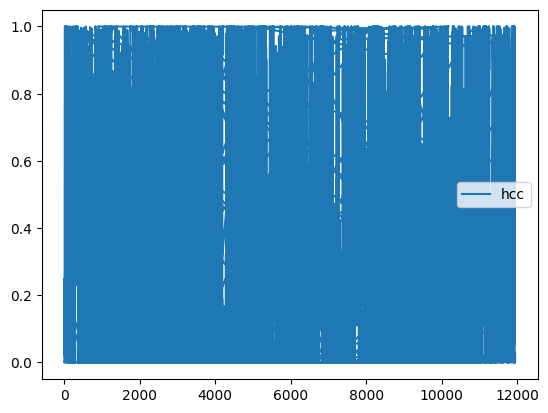

In [20]:
plot_cols = ['hcc']
plot_features = forecast_data[plot_cols]

p = plot_features.plot(subplots=True)
plot_features = forecast_data[plot_cols][:]

In [21]:
# forecast_data.info()

In [22]:
# forecast_data.head(36)

In [23]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, forecast_data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)


In [24]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [25]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()


In [36]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

trainer = pl.Trainer(
    max_epochs=3,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=False
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 44.4k


In [37]:
print(type(tft))
print(issubclass(TemporalFusionTransformer, pl.LightningModule))  # Should print True


<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
True


In [38]:
# tuner = Tuner(trainer)
# res = tuner.lr_find(
#      tft,
#      train_dataloaders=train_dataloader,
#      val_dataloaders=val_dataloader,
#      max_lr=30.0,
#      min_lr=1e-6,
#  )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [39]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.9 K  | train
3  | prescalers                         | ModuleDict                      | 368    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 4.6 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.3 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.6 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)